<center><font size="4"><span style="color:blue">Demonstration 4: example of early classification implementation</span></font></center>

This is a demonstration of the 3W dataset, the first realistic and public dataset with rare undesirable real events in oil wells as far as the authors of this work know. It can be used in development of several kinds of techniques and methods for different tasks associated with undesirable events in oil and gas wells.

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering**.

**_Disclamer_**

_This notebook presents a demonstration. As we have not experienced all the possibilities, for example in terms of approaches, methods, parameter values, and metrics, we do not argue that the results presented here are optimal. However, these results can be used as initial benchmark for other works._

# 1. Introduction

This notebook presents the results of a specific task of interest (early classification) applied to the 3W dataset is presented next. In this task, classifications of observations of the transient or in-regime periods of a type of undesirable event classified as being from the transient period of this type of undesirable event are considered to be anticipated. This type of classification is beneficial because it allows a longer time for actions to restore the normal state of the well. 

# 2. Imports and Configurations

In [1]:
import pandas as pd
import numpy as np
import logging
import warnings
import itertools
from matplotlib import pyplot as plt
from time import time
from pathlib import Path
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [2]:
logging.getLogger('tsfresh').setLevel(logging.ERROR)
warnings.simplefilter(action='ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [4]:
data_path = Path('..', 'data')
random_state = 1
clfs = {'MLP' : MLPClassifier(random_state=random_state),
        'LDA' : LinearDiscriminantAnalysis(),
        'DT'  : DecisionTreeClassifier(random_state=random_state),
        }
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class']
normal_class_code = 0
abnormal_classes_codes = [1, 2]
downsample_rate = 1               # No need of downsample
sample_size_default = 5*60        # In observations = seconds
sample_size_normal_period = 5*60  # In observations = seconds
max_samples_per_period = 15       # Limitation for safety
df_fc_p = MinimalFCParameters()   # See tsfresh's documentation
df_fc_p.pop('sum_values')         # Excludes inappropriate feature
df_fc_p.pop('length')             # Excludes inappropriate feature
max_nan_percent = 0.1             # For selection of useful variables
std_vars_min = 0.01               # For selection of useful variables
disable_progressbar = True        # For less output

# 3. Early Classification Implementation

The following cells implement a method for early classification. The more relevant choices of this method are:

1. Only real instances with undesirable events of the types 1 or 2 are used. The types of events that do not have transient period are not appropriate for this demonstration;
1. The possible concept drift of normality is not considered. The used method supposes that normality and the undesirable events do not depend on time or specific well;
1. Only classifiers (three in total) implemented in the scikit-learn package are used. As optimization of metrics is not a focus of this work, the parameters of the classifiers are not optimized;
1. A specific sampling strategy with sliding window is used for each type of period of training instances. In normal periods, the last observations are privileged. In transient periods, it is sought to use observations throughout the transient as a whole. In in-regime periods, the first observations are privileged;
1. The sampling strategy in testing instances is different. Information about the periods are not used and it is sought to use observations throughout the instance as a whole;
1. Before each round of training and testing:
    1. The used instances are appropriately normalized with z-score;
    1. The variables of real instances used for training that have a number of NaNs above a threshold or that have a standard deviation below another threshold are discarded.
1. For the sake of execution time, it is used a subset of the minimal set of features of the tsfresh package. Other features can improve the classifiers performances;
1. All required random_state are assigned to a constant for results to be reproducible.

In [5]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [6]:
def load_instance(instance_path):
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), 'invalid columns in the file {}: {}'\
            .format(str(instance_path), str(df.columns.tolist()))
        return df
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

In [7]:
def load_and_downsample_instances(instances, downsample_rate, source, instance_id):
    df_instances = pd.DataFrame()
    for _, row in instances.iterrows():
        _, instance_path = row
        df = load_instance(instance_path).iloc[::downsample_rate, :]
        df['instance_id'] = instance_id
        instance_id += 1
        df_instances = pd.concat([df_instances, df])
    df_instances['source'] = source
    return df_instances.reset_index(drop=True), instance_id

In [8]:
def extract_samples_train(df, df_samples_train, df_y_train, sample_id):
    instance = df['instance_id'].iloc[0]
    f_idxs = []
    l_idxs = []
    
    # Gets the observations labels and their unequivocal set
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))
        
    # Retrieves the undesirable_event_code
    undesirable_event_code = [l%100 for l in set_ols if (l > normal_class_code)][0]
    
    # Discards the source and the observations labels and replaces all nan with 
    # 0 (tsfresh's requirement)
    df_vars = df.drop(['source', 'class'], axis=1).fillna(0)

    # Extracts samples from the normal period (if it exists)
    #
    if normal_class_code in set_ols:
        # Gets indexes (first and last) without overlap with other periods
        f_idx = ols.index(normal_class_code)
        l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size_normal_period
        if (max_samples) > 0:  
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = sample_size_normal_period
            step = min(step_wanted, step_max)

            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = l_idx-sample_size_normal_period+1-(num_samples-1-idx)*step
                l_idx_c = f_idx_c+sample_size_normal_period
                f_idxs.append(f_idx_c)
                l_idxs.append(l_idx_c)                
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_samples_train = df_samples_train.append(df_sample)
                df_y_train = df_y_train.append({'instance':instance, 
                                                'y':normal_class_code},
                                               ignore_index=True)
                sample_id += 1

    # Extracts samples from the transient period (if it exists)
    #
    transient_code = undesirable_event_code + 100
    if transient_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # of this period
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size_default-1) > 0:
            f_idx = f_idx-(sample_size_default-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        
    
        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size_default
        if (max_samples) > 0:
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = np.inf
            step = min(step_wanted, step_max)

            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = f_idx+idx*step
                l_idx_c = f_idx_c+sample_size_default
                f_idxs.append(f_idx_c)
                l_idxs.append(l_idx_c)                
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_samples_train = df_samples_train.append(df_sample)
                df_y_train = df_y_train.append({'instance':instance, 
                                                'y':transient_code},
                                               ignore_index=True)
                sample_id += 1
    
    # Extracts samples from the in-regime period (if it exists)
    #
    if undesirable_event_code in set_ols:
        # Gets indexes (first and last) with possible overlap at the beginning 
        # or end of this period
        f_idx = ols.index(undesirable_event_code)
        if f_idx-(sample_size_default-1) > 0:
            f_idx = f_idx-(sample_size_default-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(undesirable_event_code)
        if l_idx+(sample_size_default-1) < len(ols)-1:
            l_idx = l_idx+(sample_size_default-1) 
        else:
            l_idx = len(ols)-1
  
        # Defines the proper step and extracts samples
        max_samples = l_idx-f_idx+1-sample_size_default
        if (max_samples) > 0 :
            num_samples = min(max_samples_per_period, max_samples)
            if num_samples == max_samples:
                step_max = 1 
            else:
                step_max = (max_samples-1) // (max_samples_per_period-1)
            step_wanted = sample_size_default
            step = min(step_wanted, step_max)
    
            # Extracts samples
            for idx in range(num_samples):
                f_idx_c = f_idx+idx*step
                l_idx_c = f_idx_c+sample_size_default
                f_idxs.append(f_idx_c)
                l_idxs.append(l_idx_c)
                #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
                df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
                df_sample.insert(loc=0, column='id', value=sample_id)
                df_samples_train = df_samples_train.append(df_sample)
                df_y_train = df_y_train.append({'instance':instance, 
                                                'y':undesirable_event_code}, 
                                               ignore_index=True)
                sample_id += 1
    
    return df_samples_train, df_y_train, sample_id 

In [9]:
def extract_samples_test(df, df_samples_test, df_y_test, sample_id):
    instance = df['instance_id'].iloc[0]
    f_idxs = []
    l_idxs = []
    
    # Gets the observations labels
    ols = list(df['class'].fillna(method='ffill'))    
    
    # Discards the source and the observations labels and replaces all nan with 
    # 0 (tsfresh's requirement)
    df_vars = df.drop(['source', 'class'], axis=1).fillna(0)    
    
    # Extracts samples from the instance as a whole
    f_idx = 0
    l_idx = len(df)-1  

    # Defines the proper step and extracts samples
    max_samples = l_idx-f_idx+1-sample_size_default
    if (max_samples) > 0:
        num_samples = min(3*max_samples_per_period, max_samples)
        if num_samples == max_samples:
            step_max = 1 
        else:
            step_max = (max_samples-1) // (3*max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)

        # Extracts samples
        for idx in range(num_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size_default
            f_idxs.append(f_idx_c)
            l_idxs.append(l_idx_c)                
            #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            df_y_test = df_y_test.append({'instance':instance, 'y':ols[l_idx_c]},
                                         ignore_index=True)
            sample_id += 1
            
    return df_samples_test, df_y_test, sample_id

In [10]:
def show_cm(cm, clf_name, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(clf_name)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()
    plt.show()

In [11]:
def train_test_calc_cms(X_train, y_train, X_test, y_test, cms, clfs, labels):
    for clf_name, clf in clfs.items():
        try:
            # Train
            t0 = time()
            clf.fit(X_train, y_train)
            t_train = time() - t0
                
            # Test
            t0 = time()
            y_pred = clf.predict(X_test)
            t_test = time() - t0
            
            # Plots actual and predicted labels
            fig = plt.figure(figsize=(12,1))
            ax = fig.add_subplot(111)
            plt.plot(y_pred, marker=11, color='orange', linestyle='')
            plt.plot(y_test, marker=10, color='green', linestyle='')            
            ax.grid(False)
            ax.set_title(clf_name)
            ax.set_xlabel('Sample')
            ax.legend(['Predicted labels', 'Actual labels'])
            plt.show()            
           
            # Calculates and updates the confusion matrix
            cm = confusion_matrix(y_test, y_pred, labels=labels)
            cms[clf_name] += cm
            #show_cm(cm, clf_name, labels)
            
        except Exception as e:
            print('error in training/testing classifier: {}'.format(e))

    return cms

In [12]:
def loio(n):
    all_i = range(n)
    for i in all_i:
        test_i = set([i])
        train_i = set(all_i)-test_i
        yield train_i, test_i

In [13]:
# Gets all real instances but maintains only those with the specified undesirable events
instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
instances = instances.loc[instances.iloc[:, 0].isin(abnormal_classes_codes)].reset_index(drop=True)

In [14]:
# Loads all real, simulated and drawn instances and applies downsample
instance_id = 0
df_instances, instance_id  = load_and_downsample_instances(instances,
                                                           downsample_rate,
                                                           'real', 
                                                           instance_id)

testing/training instance: {0}/{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


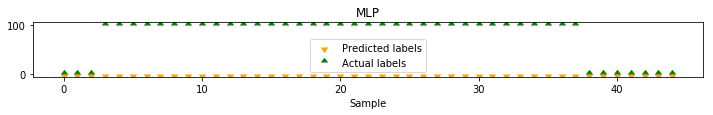

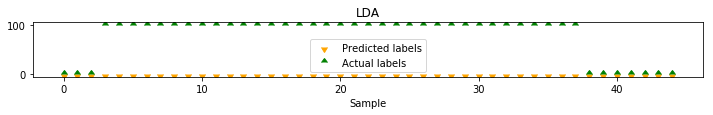

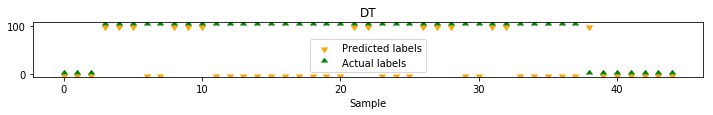

testing/training instance: {1}/{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


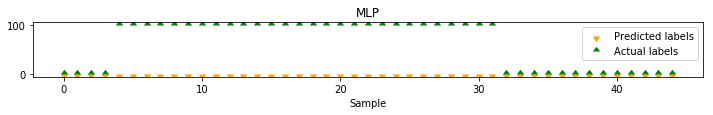

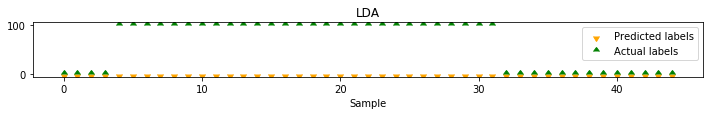

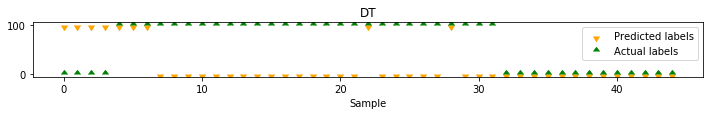

testing/training instance: {2}/{0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


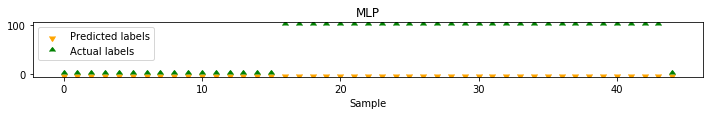

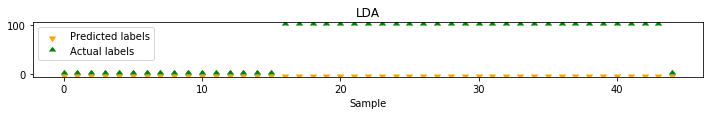

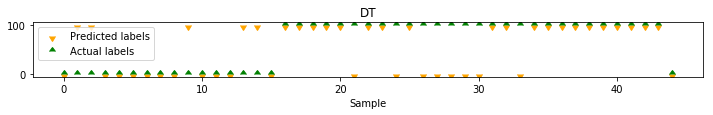

testing/training instance: {3}/{0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


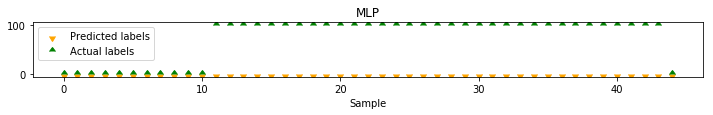

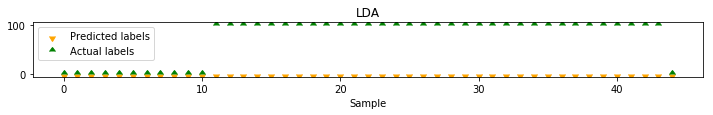

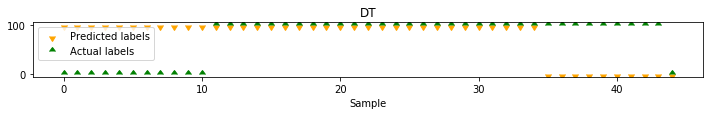

testing/training instance: {4}/{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


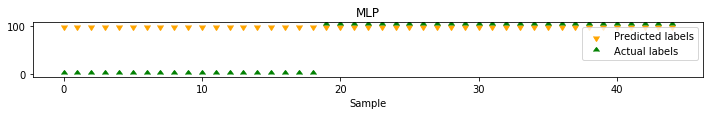

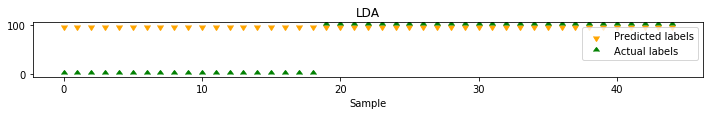

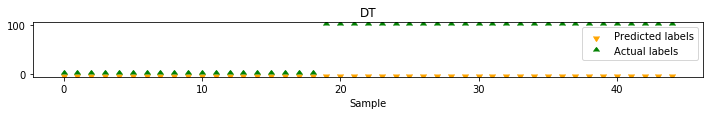

testing/training instance: {5}/{0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


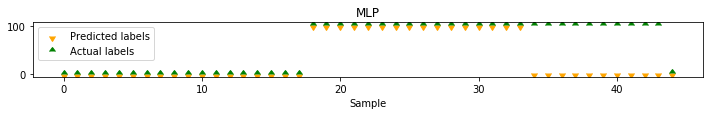

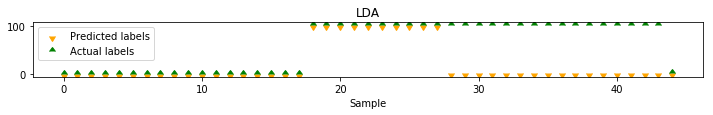

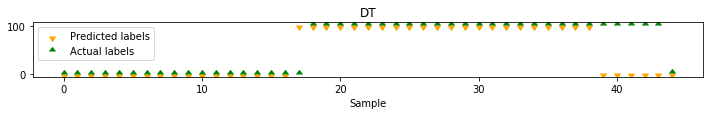

testing/training instance: {6}/{0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


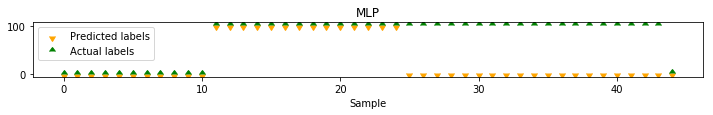

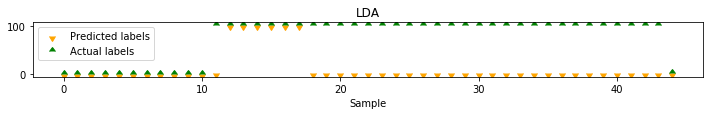

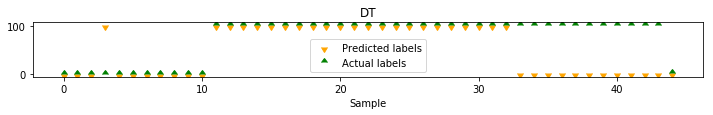

testing/training instance: {7}/{0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


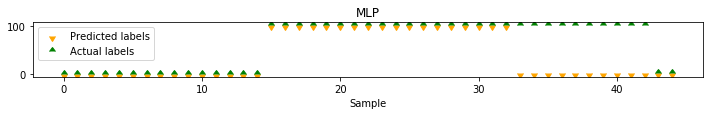

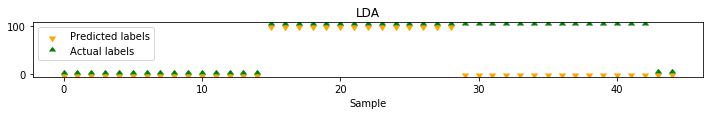

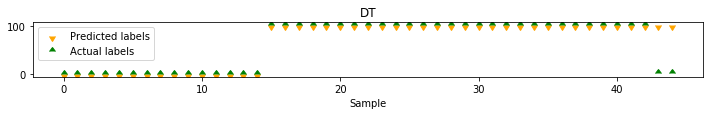

testing/training instance: {8}/{0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


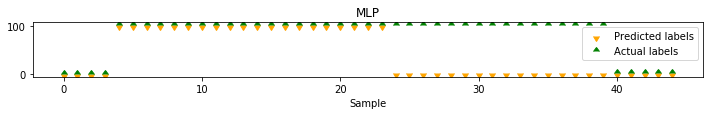

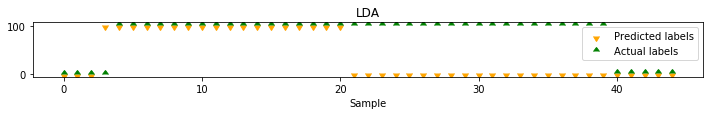

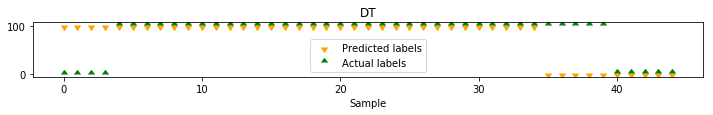

testing/training instance: {9}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


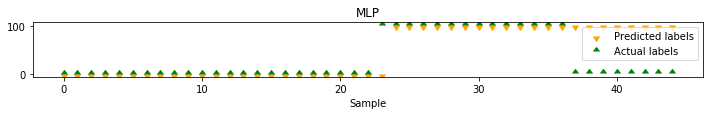

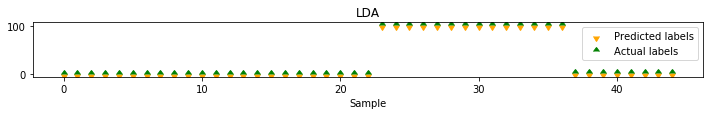

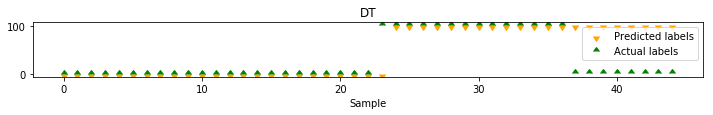

testing/training instance: {10}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


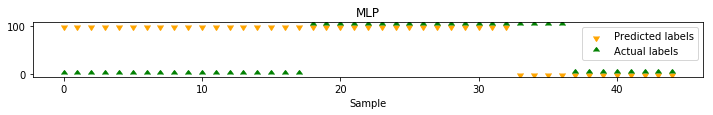

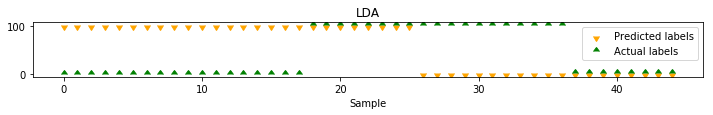

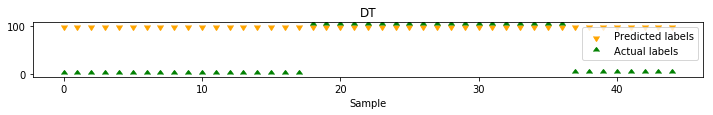

testing/training instance: {11}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


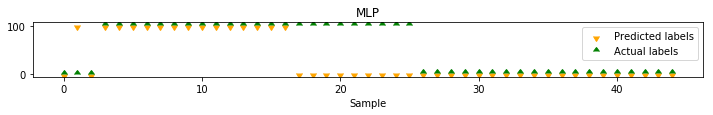

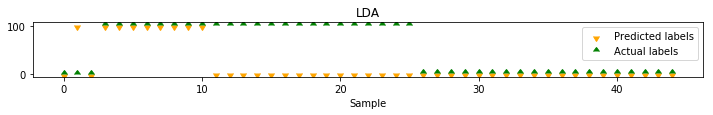

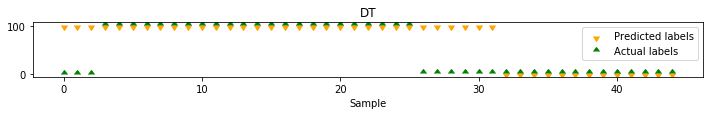

testing/training instance: {12}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


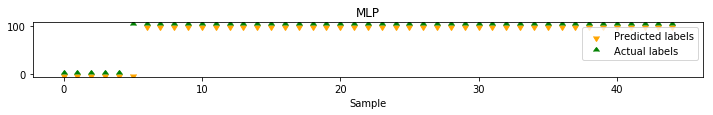

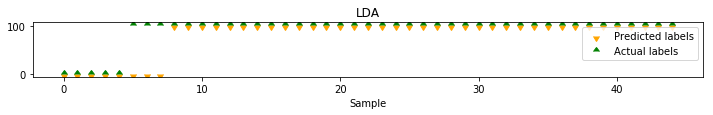

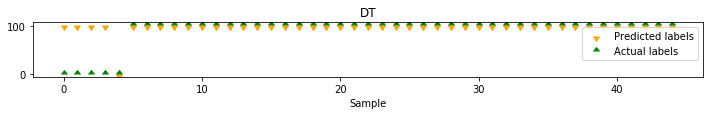

testing/training instance: {13}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


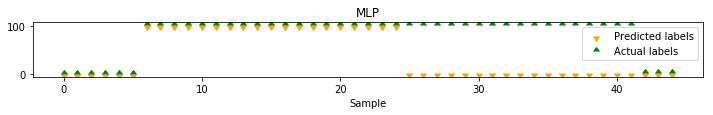

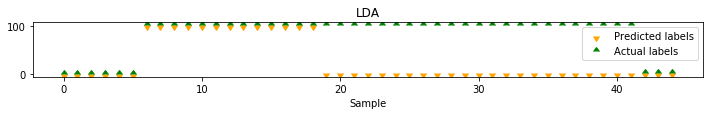

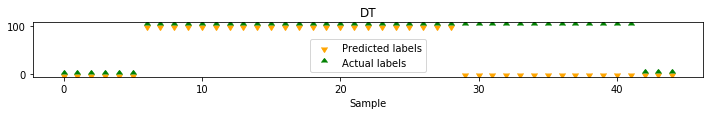

testing/training instance: {14}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


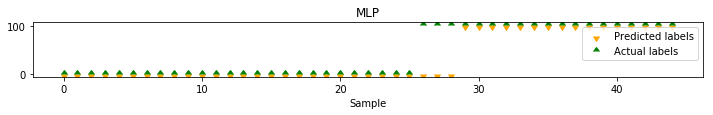

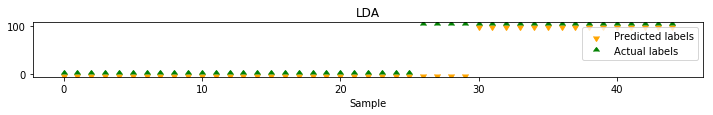

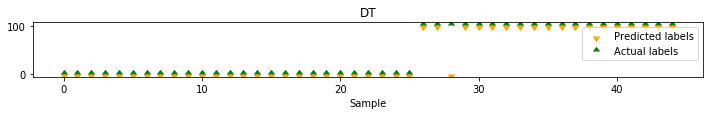

testing/training instance: {15}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


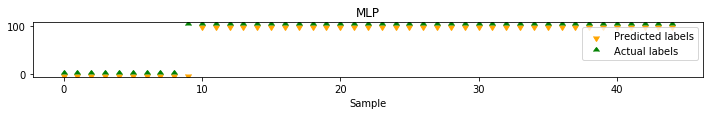

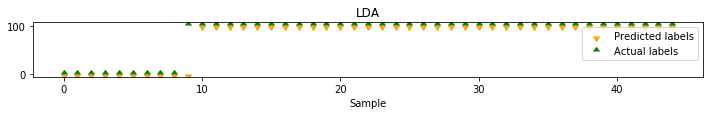

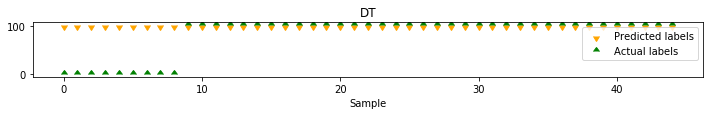

testing/training instance: {16}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


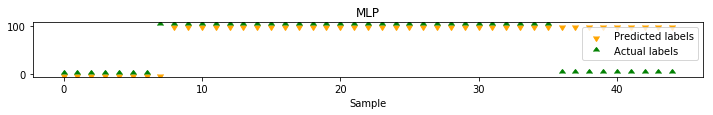

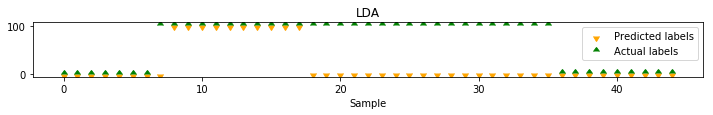

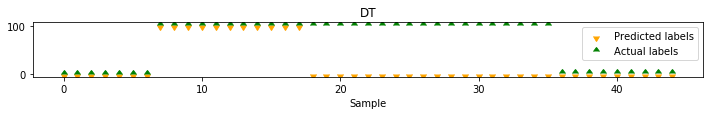

testing/training instance: {17}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26}


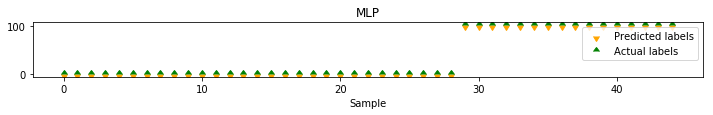

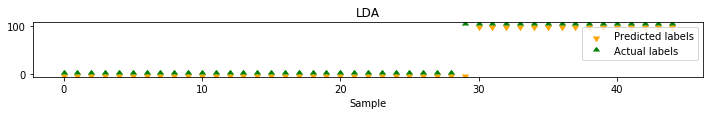

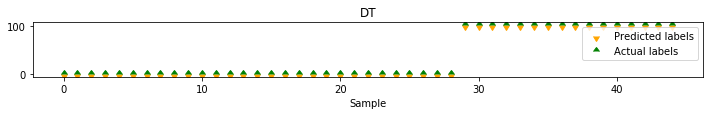

testing/training instance: {18}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26}


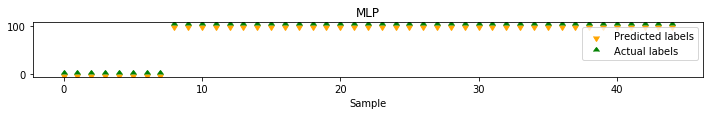

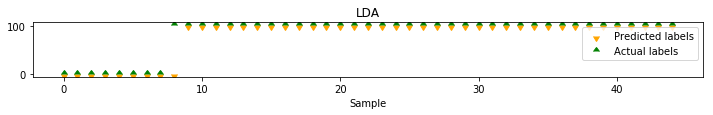

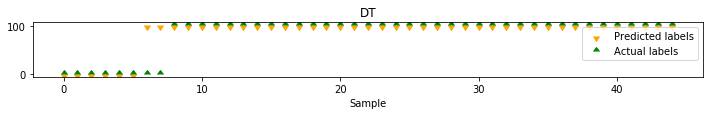

testing/training instance: {19}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26}


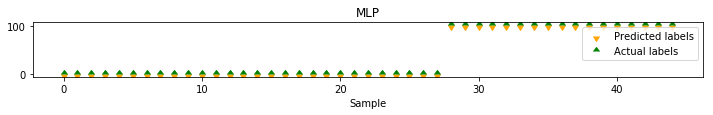

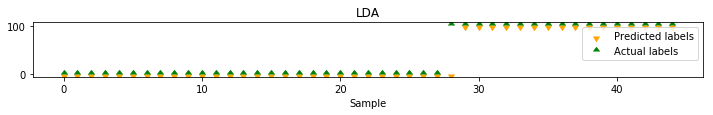

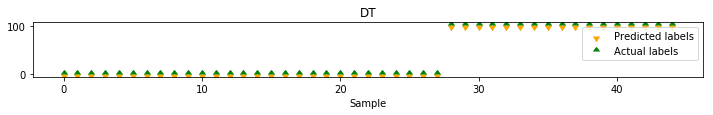

testing/training instance: {20}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26}


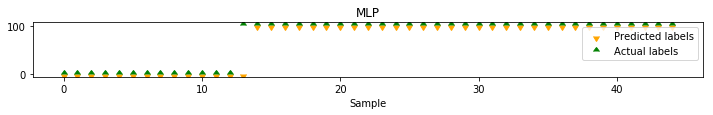

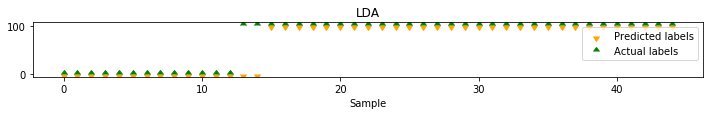

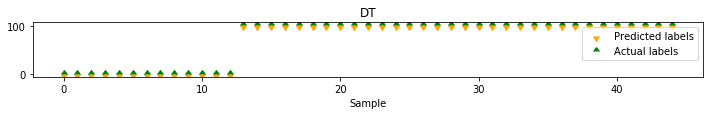

testing/training instance: {21}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26}


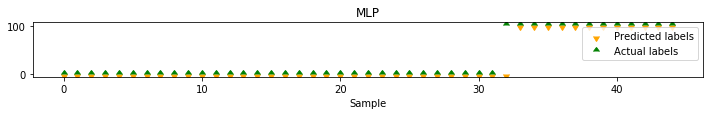

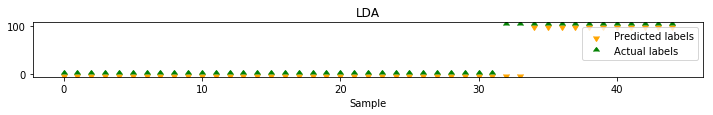

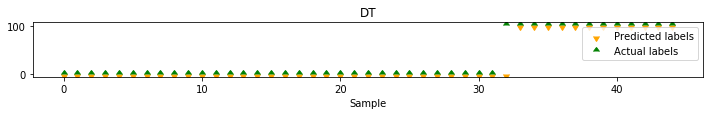

testing/training instance: {22}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26}


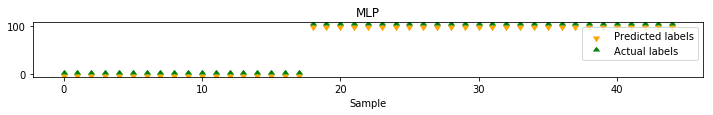

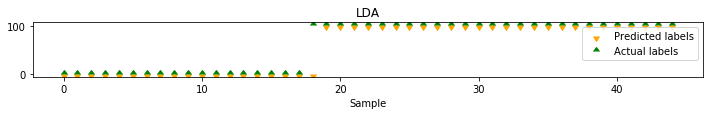

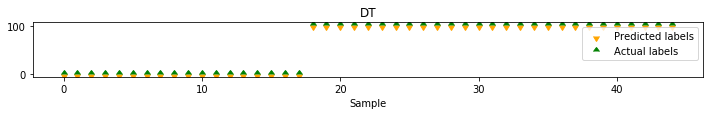

testing/training instance: {23}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26}


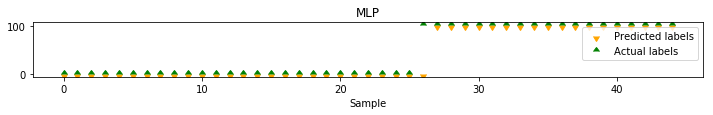

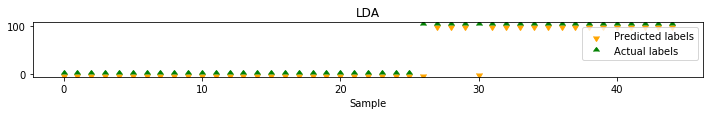

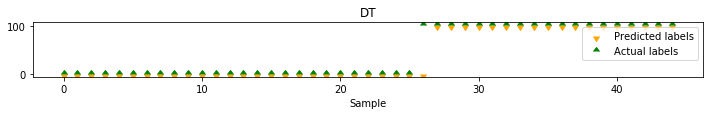

testing/training instance: {24}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26}


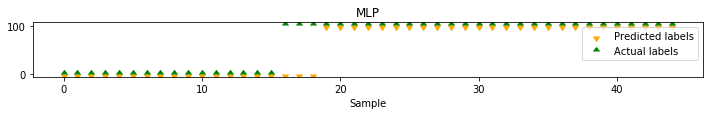

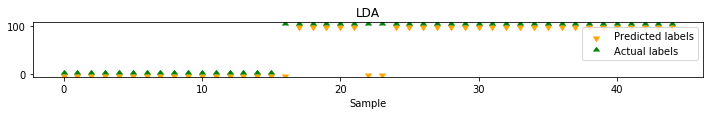

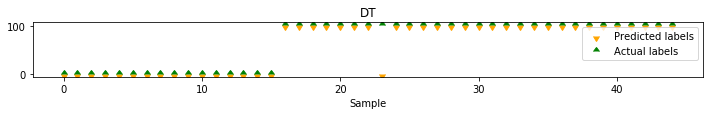

testing/training instance: {25}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26}


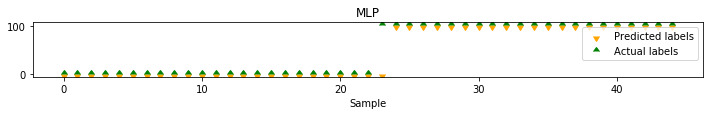

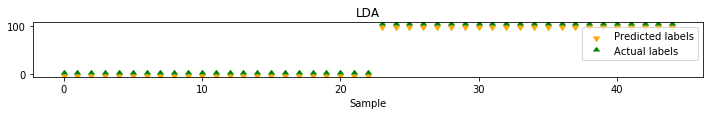

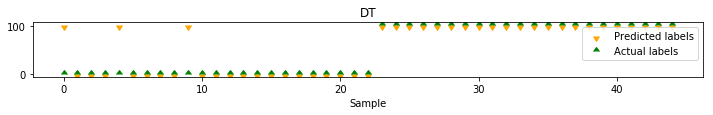

testing/training instance: {26}/{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}


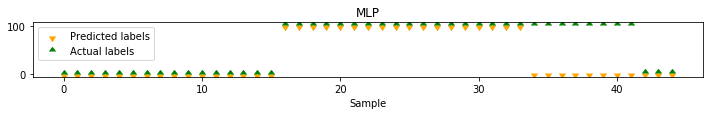

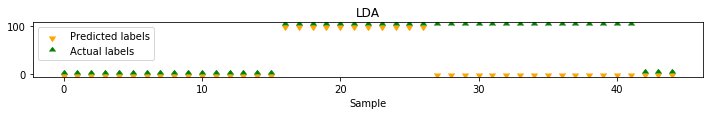

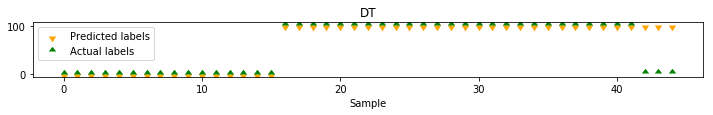

In [15]:
# Initializes a confusion matrix for each classifier
labels = sorted(df_instances['class'].fillna(0).unique().astype(int))
cms = {}
for clf_name, _ in clfs.items():
    cms[clf_name] = np.zeros([len(labels), len(labels)])
    
# For each round of a cross-validation with the 'leave one instance out' schema
scaler = preprocessing.StandardScaler()
for train_i, test_i in loio(len(instances)):
    print('testing/training instance: {}/{}'.format(test_i, train_i))
    
    # Drops the bad vars
    idxs = df_instances['instance_id'].isin(train_i)
    good_vars = np.isnan(df_instances.loc[idxs][vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_instances.loc[idxs][vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_instances_good_vars = df_instances.drop(columns=bad_vars, errors='ignore')  

    idxs_test  = df_instances_good_vars['instance_id'].isin(test_i)
    idxs_train = df_instances_good_vars['instance_id'].isin(train_i)
    df_instances_test  = df_instances_good_vars.loc[idxs_test].reset_index(drop=True)
    df_instances_train = df_instances_good_vars.loc[idxs_train].reset_index(drop=True)

    df_instances_train[good_vars] = scaler.fit_transform(df_instances_train[good_vars])
    df_instances_test[good_vars] = scaler.transform(df_instances_test[good_vars])
        
    df_samples_train = pd.DataFrame()
    df_samples_test  = pd.DataFrame()
    df_y_train = pd.DataFrame()
    df_y_test  = pd.DataFrame()
    sample_id = 0

    # Extracts samples from each training instance
    for instance in set(df_instances_train['instance_id']):
        #print('extracting samples from instance {}'.format(instance))            
        df = df_instances_train.loc[df_instances_train['instance_id']==instance]
        ret = extract_samples_train(df, df_samples_train, df_y_train, sample_id)
        df_samples_train, df_y_train, sample_id = ret

    # Extracts samples from the testing instance            
    ret = extract_samples_test(df_instances_test, df_samples_test, df_y_test, sample_id)
    df_samples_test, df_y_test, sample_id = ret
    
    # Drops the unnecessary columns
    df_samples_train = df_samples_train.drop(['instance_id'], axis=1)
    df_samples_test  = df_samples_test.drop(['instance_id'], axis=1)
    
    # Changes types of the good vars to avoid problems with inf
    df_samples_train[good_vars] = df_samples_train[good_vars].astype('float32')
    df_samples_test[good_vars]  = df_samples_test[good_vars].astype('float32')
            
    # Changes types of the labels (tsfresh's requirement)
    y_train = np.array(df_y_train['y'], dtype=int)
    y_test  = np.array(df_y_test['y'], dtype=int)
    
    # Extracts features from samples
    X_train = extract_features(df_samples_train, 
                               column_id='id', 
                               column_sort='timestamp', 
                               default_fc_parameters=df_fc_p,
                               impute_function=impute,
                               n_jobs=0,
                               disable_progressbar=disable_progressbar)
    X_train = X_train.reset_index(drop=True)
    X_test = extract_features(df_samples_test, 
                              column_id='id', 
                              column_sort='timestamp',
                              default_fc_parameters=df_fc_p,
                              impute_function=impute,
                              n_jobs=0,
                              disable_progressbar=disable_progressbar)
    X_test = X_test.reset_index(drop=True)
    
    # Trains, tests and calculates the confusion matrices
    cms = train_test_calc_cms(X_train, y_train, X_test, y_test, cms, clfs, labels) 

# 4. Results

The results obtained with the implemented method are presented in this section.

In [16]:
print('used features: {}'.format(list(df_fc_p.keys())))

used features: ['median', 'mean', 'standard_deviation', 'variance', 'maximum', 'minimum']


Besides the used features, three metrics are calculated for each evaluated classifier and the results are presented in the following subsections:

- *Overall Accuracy*: the overall accuracy without distinction between each transient period and its corresponding in-regime period;
- *Hit Rate*: the hit rate of a type of undesirable event without distinction between its transient and in-regime periods. In other words, the fraction of all observations of the **transient or in-regime periods** of a type of undesirable event classified as being from the **transient or in-regime periods** of this type of undesirable event;
- *Anticipation Rate*: the fraction of all observations of the **transient or in-regime periods** of a type of undesirable event classified as being from the **transient period** of this type of undesirable event.

# 4.1. Overall Accuracy

For each evaluated classifier, the confusion matrix is adapted with grouping of the corresponding transient and in-regime periods. And then the metric is calculated and presented in the following table.

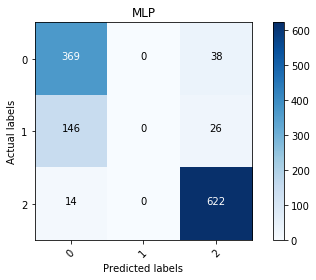

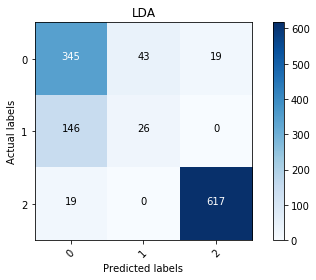

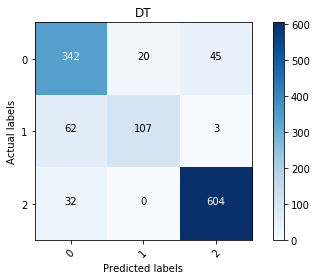

In [17]:
oaccs = pd.DataFrame(columns=['CLASSIFIER', 'OVERALL ACCURACY'])
new_labels = labels.copy()
for clf in clfs:
    cm = cms[clf]
    new_cm = cm.copy()
    i_del = []
    for l in [lt for lt in labels if lt > 100]:
        i_trans, i_in_reg = labels.index(l), labels.index(l-100)
        i_del.append(i_trans)
        new_cm[i_in_reg, :] += new_cm[i_trans, :]
        new_cm[:, i_in_reg] += new_cm[:, i_trans]
    new_cm = np.delete(new_cm, i_del, axis=0)
    new_cm = np.delete(new_cm, i_del, axis=1)
    new_labels = np.delete(new_labels, i_del, axis=0)
    show_cm(new_cm, clf, new_labels)
    oacc = np.trace(new_cm)/new_cm.sum()
    oaccs = oaccs.append({'CLASSIFIER': clf, 'OVERALL ACCURACY': oacc}, ignore_index=True)

In [18]:
oaccs.set_index('CLASSIFIER').sort_values(by=['OVERALL ACCURACY'], ascending=False)

,OVERALL ACCURACY
CLASSIFIER,
DT,0.866667
MLP,0.815638
LDA,0.813169


# 4.2. Hit Rate and Anticipation Rate

It can be observed that both rates are more favorable for the type of event 2. One factor that supports this result is the 'sample_size' parameter. According to specialists, the type of event 1 has a slower dynamics compared to the type of event 2. Therefore, the used sample size was more appropriate to capture discriminatory characteristics of the type of event 2.

In [19]:
ars = pd.DataFrame(columns=['TYPE OF EVENT', 'CLASSIFIER', 'HIT RATE', 'ANTICIPATION RATE'])
for clf in clfs:
    cm = cms[clf]
    for acc in abnormal_classes_codes:
        if (acc+100) in labels:
            i_trans, i_in_reg = labels.index(acc+100), labels.index(acc)
            all_trans_or_in_reg = cm[[i_trans, i_in_reg], :].sum()
            clsed_as_trans_or_in_reg = cm[i_trans,  [i_trans, i_in_reg]].sum() + \
                                       cm[i_in_reg, [i_trans, i_in_reg]].sum()
            clsed_as_trans = cm[[i_trans, i_in_reg], i_trans].sum()
            hr = clsed_as_trans_or_in_reg/all_trans_or_in_reg
            ar = clsed_as_trans/all_trans_or_in_reg
            ars = ars.append({'TYPE OF EVENT':acc, 
                              'CLASSIFIER': clf, 
                              'HIT RATE': hr,
                              'ANTICIPATION RATE': ar},
                            ignore_index=True)
ars.set_index('TYPE OF EVENT').sort_values(by=['TYPE OF EVENT', 'HIT RATE', 'ANTICIPATION RATE'], ascending=False)

,CLASSIFIER,HIT RATE,ANTICIPATION RATE
TYPE OF EVENT,,,
2,MLP,0.977987,0.765723
2,LDA,0.970126,0.624214
2,DT,0.949686,0.860063
1,DT,0.622093,0.348837
1,LDA,0.151163,0.151163
1,MLP,0.000000,0.000000


# 5. Conclusion

Given the results presented above, we can state that the structure of the 3W dataset permits development of classifiers that performs early classification.